In [13]:
from collections import deque
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

L, W = 4, 3 # lattice size.
G = nx.grid_2d_graph(L, W)
G_positions = G.nodes() # original node labels can be used as "coordinates"

## Explanation

So we are trying to relabel the nodes so that the left edge is first, then the bottom edge.

For example, for a 4x3 graph the order should be

$$\begin{matrix}
3 & 8 & 10 & 12 \\
2 & 7 & 9 & 11 \\
1 & 4 & 5 & 6
\end{matrix}
$$

so the new labels should be in this order: 1, 2, 3, 4, 7, 8, 5, 9, 10, 6, 11, 12.

---------------------------

What we will do is use `nx.relabel_nodes`. It takes the graph and a dictionary `d` which should map from the old label to the new label. We will store the old labels in `a`, and create a list `b` which holds the new labels in order.

We do this by setting `b=[1, 2, ..., W]`, and creating two lists `b1` and `b2`:
- b1 = $[W+1, ..., W+L-1]$   (the ones which go on the bottom edge).
- b2 = everything else.

In the above case, `b1` = $[4, 5, 6],$ `b2` = $[7, 8, 9, 10, 11, 12]$

Then do the following $L-1$ times:
- add the first element from `b1` to `b`
- add the first $(W-1)$ elements from `b2` to `b`.

(We use a deque so `popleft` is O(1).)

Finally create the desired dictionary `d` from a and b by doing `d=dict(zip(a, b))`.

[1, 2, 3, 4, 7, 8, 5, 9, 10, 6, 11, 12]


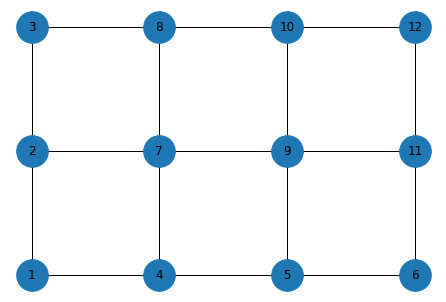

In [14]:
a = list(G.nodes)

b = list(range(1, W+1)) # left edge
b1 = deque(range(W+1, W+L)) # bottom edge
b2 = deque(range(W+L, W*L+1))

for i in range(L-1):
    b.append(b1.popleft())
    b.extend([b2.popleft() for j in range(W-1)])
    
print(b)
  
d = dict(zip(a,b))
G = nx.relabel_nodes(G,d)

# Position
pos = dict(zip(b, G_positions))

nx.draw(G, with_labels=True, node_size=1000, pos=pos)

In [15]:
# Laplacian matrix
K = nx.linalg.laplacianmatrix.laplacian_matrix(G, nodelist=list(range(1, L*W+1))).toarray()

We know that $Kx=f$ where $K$ is the Laplacian and $f$ is the net current out of a node. We will assume that Kirchoff's current law holds at all nodes except the source and sink nodes, so $f=0$ at these nodes.

However we have reordered the nodes such that the first $W$ nodes have $\phi=1$ and the next $L-1$ nodes have $\phi=0$. By decomposing the Laplacian into four parts, we can rewrite the equation as

$\begin{pmatrix} A & B^T \\ B & C \end{pmatrix} \begin{pmatrix} v \\ \textbf{x} \end{pmatrix}= \begin{pmatrix}f  \\ 0 \end{pmatrix}$

where

- the first matrix is the decomposition of the Laplacian
- $v$ is a vector with $W$ 1's and $L-1$ 0's (potentials at the boundary)
- $x$ is the vector of potentials we want to calculate
- $f$ is the net current out of the boundary nodes. 

We can use the second row of this matrix equation to deduce that $\textbf{x}=-C^{-1}Bv$.


In [16]:
# constructing v, extracting B, C and solving for x
v = np.array([1]*W + [0]*(L-1))
B = K[-(W-1)*(L-1):, :W+L-1]
C = K[-(W-1)*(L-1):, -(W-1)*(L-1):]

x = (-np.linalg.inv(C) @ B @ v).flatten()

potentials = np.concatenate([v, x])
potentials

array([1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.46975089, 0.61921708, 0.25978648, 0.38790036,
       0.18149466, 0.28469751])

# Fix this

C:\Users\Julian\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


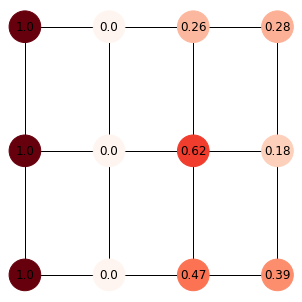

In [17]:
# Make the node labels the potentials.
labels = {}
i = 0
for node in G:
    labels[node] = round(potentials[i], 2)
    i += 1
nx.relabel_nodes(G, labels)

# Draw
plt.figure(figsize=(4, 4))
fig = nx.draw(G,node_size=1000, pos=pos, with_labels=True, labels=labels, cmap='Reds', node_color=potentials)
plt.show()